In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import time

In [ ]:
# Load dataset
df = pd.read_csv("heart_2022.csv")

In [ ]:
# Define target and features
target = 'HadHeartAttack'
features = ['AgeCategory', 'BMI', 'PhysicalHealthDays', 'SleepHours', 'SmokerStatus']

X = df[features]
y = df[target].apply(lambda x: 1 if x == 'Yes' else 0)  # Encode target as binary (1 = Yes, 0 = No)

In [ ]:
# Define preprocessing for numerical and categorical features
numerical_features = ['BMI', 'PhysicalHealthDays', 'SleepHours']
categorical_features = ['AgeCategory', 'SmokerStatus']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ]
)

In [ ]:
# Apply preprocessing to the entire dataset
X_preprocessed = preprocessor.fit_transform(X)

In [ ]:
# Get feature names after preprocessing
numerical_names = numerical_features
categorical_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features).tolist()
feature_names = numerical_names + categorical_names

In [ ]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
# Split resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    'XGBoost': XGBClassifier(n_jobs=-1, use_label_encoder=False, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(n_jobs=-1, max_iter=1000)
}

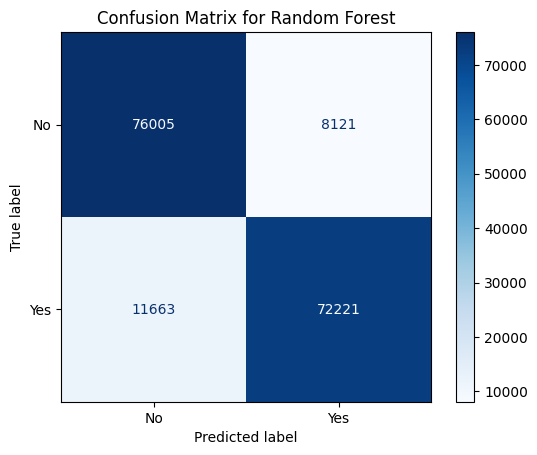

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:56:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


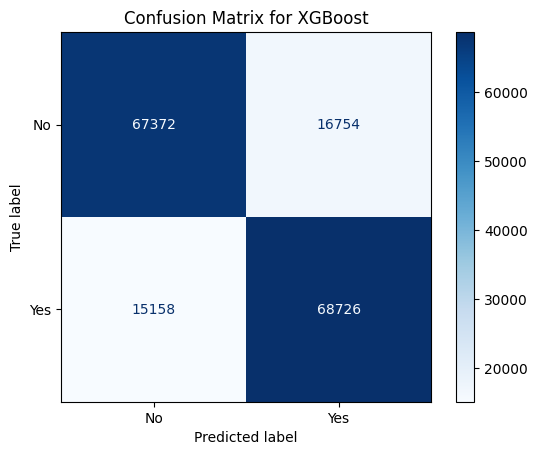

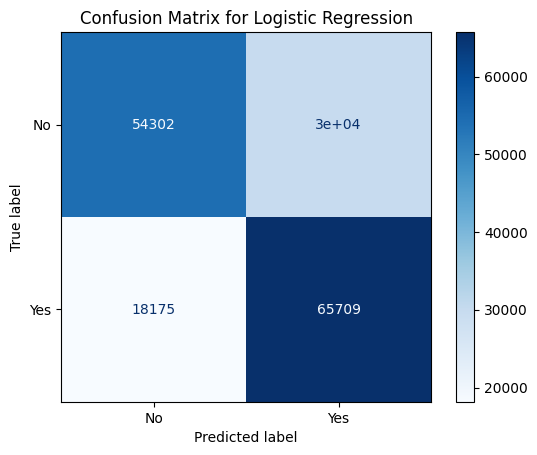

                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0        Random Forest  0.882245   0.898920  0.860963  0.879532  0.945912   
1              XGBoost  0.810059   0.804001  0.819298  0.811577  0.906337   
2  Logistic Regression  0.714309   0.687815  0.783332  0.732472  0.783078   

   Execution Time  
0      150.073329  
1       13.591167  
2       21.604642  


In [ ]:
# Train and evaluate model
import time
import numpy as np

results = []

for model_name, model in models.items():

    start_time = time.time()

    # Fit the model on the resampled training data
    model.fit(X_train, y_train)

    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    results.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'Execution Time': time.time() - start_time
    })

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

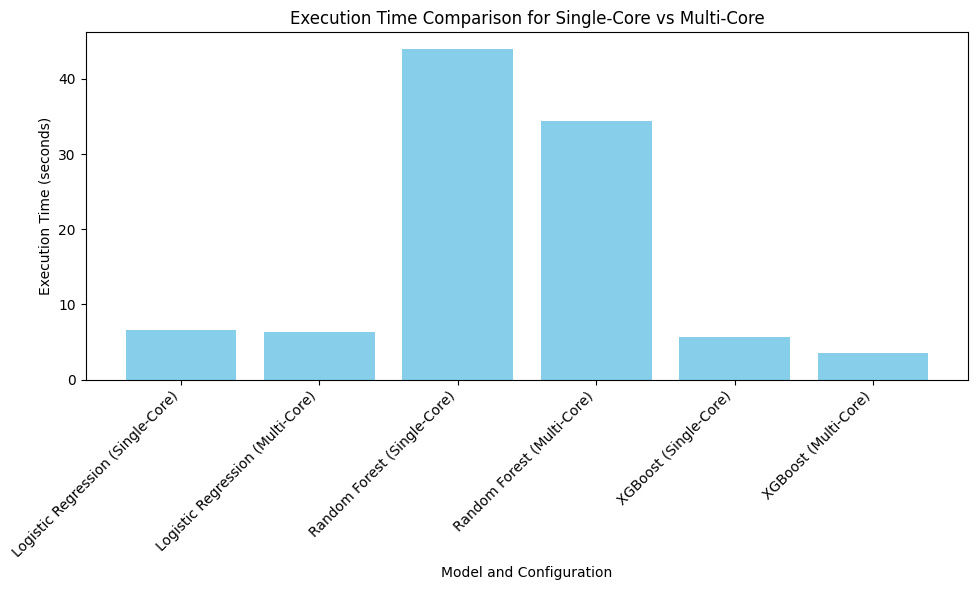

In [ ]:
import matplotlib.pyplot as plt

# Data for the chart
models = ['Logistic Regression (Single-Core)', 'Logistic Regression (Multi-Core)',
          'Random Forest (Single-Core)', 'Random Forest (Multi-Core)',
          'XGBoost (Single-Core)', 'XGBoost (Multi-Core)']

times = [6.6, 6.3, 44.0, 34.4, 5.7, 3.5]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, times, color='skyblue')
plt.xlabel('Model and Configuration')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison for Single-Core vs Multi-Core')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
